In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from PIL import Image
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt

# 이미지 전처리를 위한 transform 설정
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [22]:
# CustomDataset 클래스 정의
class CustomDataset(Dataset):
    def __init__(self, img_dir, annotations_dir, transform=None):
        self.img_dir = img_dir
        self.annotations_dir = annotations_dir
        self.transform = transform
        self.img_names = [x for x in os.listdir(img_dir) if x.endswith('.jpg')]
        self.class_to_idx = {'apple': 0, 'banana': 1, 'orange': 2} # 예시, 실제 클래스에 맞게 수정 필요
        self.classes = list(self.class_to_idx.keys())


    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_names[idx])
        annotation_path = os.path.join(self.annotations_dir, self.img_names[idx].replace('.jpg', '.xml'))
        image = Image.open(img_path).convert('RGB')
        label = self.extract_label(annotation_path)
        if self.transform:
            image = self.transform(image)
        return image, label

    def extract_label(self, annotation_path):
        tree = ET.parse(annotation_path)
        root = tree.getroot()
        label = root.find('object').find('name').text
        return self.class_to_idx[label]

# 데이터셋 및 데이터 로더 인스턴스화
train_dataset = CustomDataset('../데이터셋/train_zip/train/', '../데이터셋/train_zip/train/', transform=transform)
test_dataset = CustomDataset('../데이터셋/test_zip/test/', '../데이터셋/test_zip/test/', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

In [30]:
activation = {}  # 계층별 출력을 저장할 딕셔너리

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [37]:
class GoogleNetModified(nn.Module):
    def __init__(self, num_classes=3):
        super(GoogleNetModified, self).__init__()
        self.original_model = models.googlenet(pretrained=True)
        # GoogLeNet의 사전 훈련된 모델의 features 부분을 가져옵니다.
        self.pretrained_features = nn.Sequential(*list(self.original_model.children())[:-2])
        self.avgpool = self.original_model.avgpool
        self.classifier = nn.Linear(1024, num_classes)

        # 특정 계층의 출력을 저장하기 위한 훅을 등록합니다.
        self.register_hooks()

    def register_hooks(self):
        # 계층의 인덱스를 기반으로 특정 계층에 대한 훅을 등록합니다.
        layers_to_hook = {
            0: 'conv1',  # 첫 번째 Conv 계층
            3: 'conv2_3x3_reduce',  # 세 번째 Conv 계층
            4: 'conv2_3x3',  # 네 번째 Conv 계층
        }
        for idx, name in layers_to_hook.items():
            layer = self.pretrained_features[idx]
            layer.register_forward_hook(get_activation(name))

        
    def forward(self, x):
        # 사전 훈련된 모델의 특징 추출 부분을 통과합니다.
        x = self.pretrained_features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GoogleNetModified(num_classes=len(train_dataset.classes)).to(device)

In [38]:
def visualize_feature_map(feature_map_batch, img_names, num_images=1, num_columns=8):
    for img_index in range(num_images):
        # 배치에서 선택된 이미지의 특징 맵을 가져옵니다.
        feature_map = feature_map_batch[img_index]
        num_feature_maps = feature_map.size(0)
        num_rows = int(np.ceil(num_feature_maps / num_columns))
        
        # 선택된 이미지에 대한 특징 맵 시각화
        plt.figure(figsize=(num_columns * 2, num_rows * 2))
        plt.suptitle(f"Feature Maps for Image: {img_names[img_index]}", fontsize=16)
        for i in range(num_feature_maps):
            plt.subplot(num_rows, num_columns, i+1)
            plt.imshow(feature_map[i].cpu().detach().numpy(), cmap='viridis')
            plt.axis('off')
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

In [39]:
def visualize_activation(activation, layer_names, num_images=1, num_columns=8):
    for name in layer_names:
        feature_map_batch = activation[name]
        
        # 각 계층의 첫 번째 이미지에 대한 특징 맵을 시각화
        # 이 예에서는 배치의 첫 번째 이미지만 시각화하도록 설정
        img_names = [f"Layer: {name}"]
        
        # feature_map_batch에서 시각화하고자 하는 이미지 수와 열의 수를 지정
        visualize_feature_map(feature_map_batch, img_names, num_images, num_columns)


In [40]:
# 모델 훈련 함수 수정
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
                
        epoch_loss = running_loss / len(train_loader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}')

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Epoch 1/10, Loss: 0.0003
Epoch 2/10, Loss: 0.0003
Epoch 3/10, Loss: 0.0003
Epoch 4/10, Loss: 0.0003
Epoch 5/10, Loss: 0.0003
Epoch 6/10, Loss: 0.0004
Epoch 7/10, Loss: 0.0004
Epoch 8/10, Loss: 0.0002
Epoch 9/10, Loss: 0.0002
Epoch 10/10, Loss: 0.0005


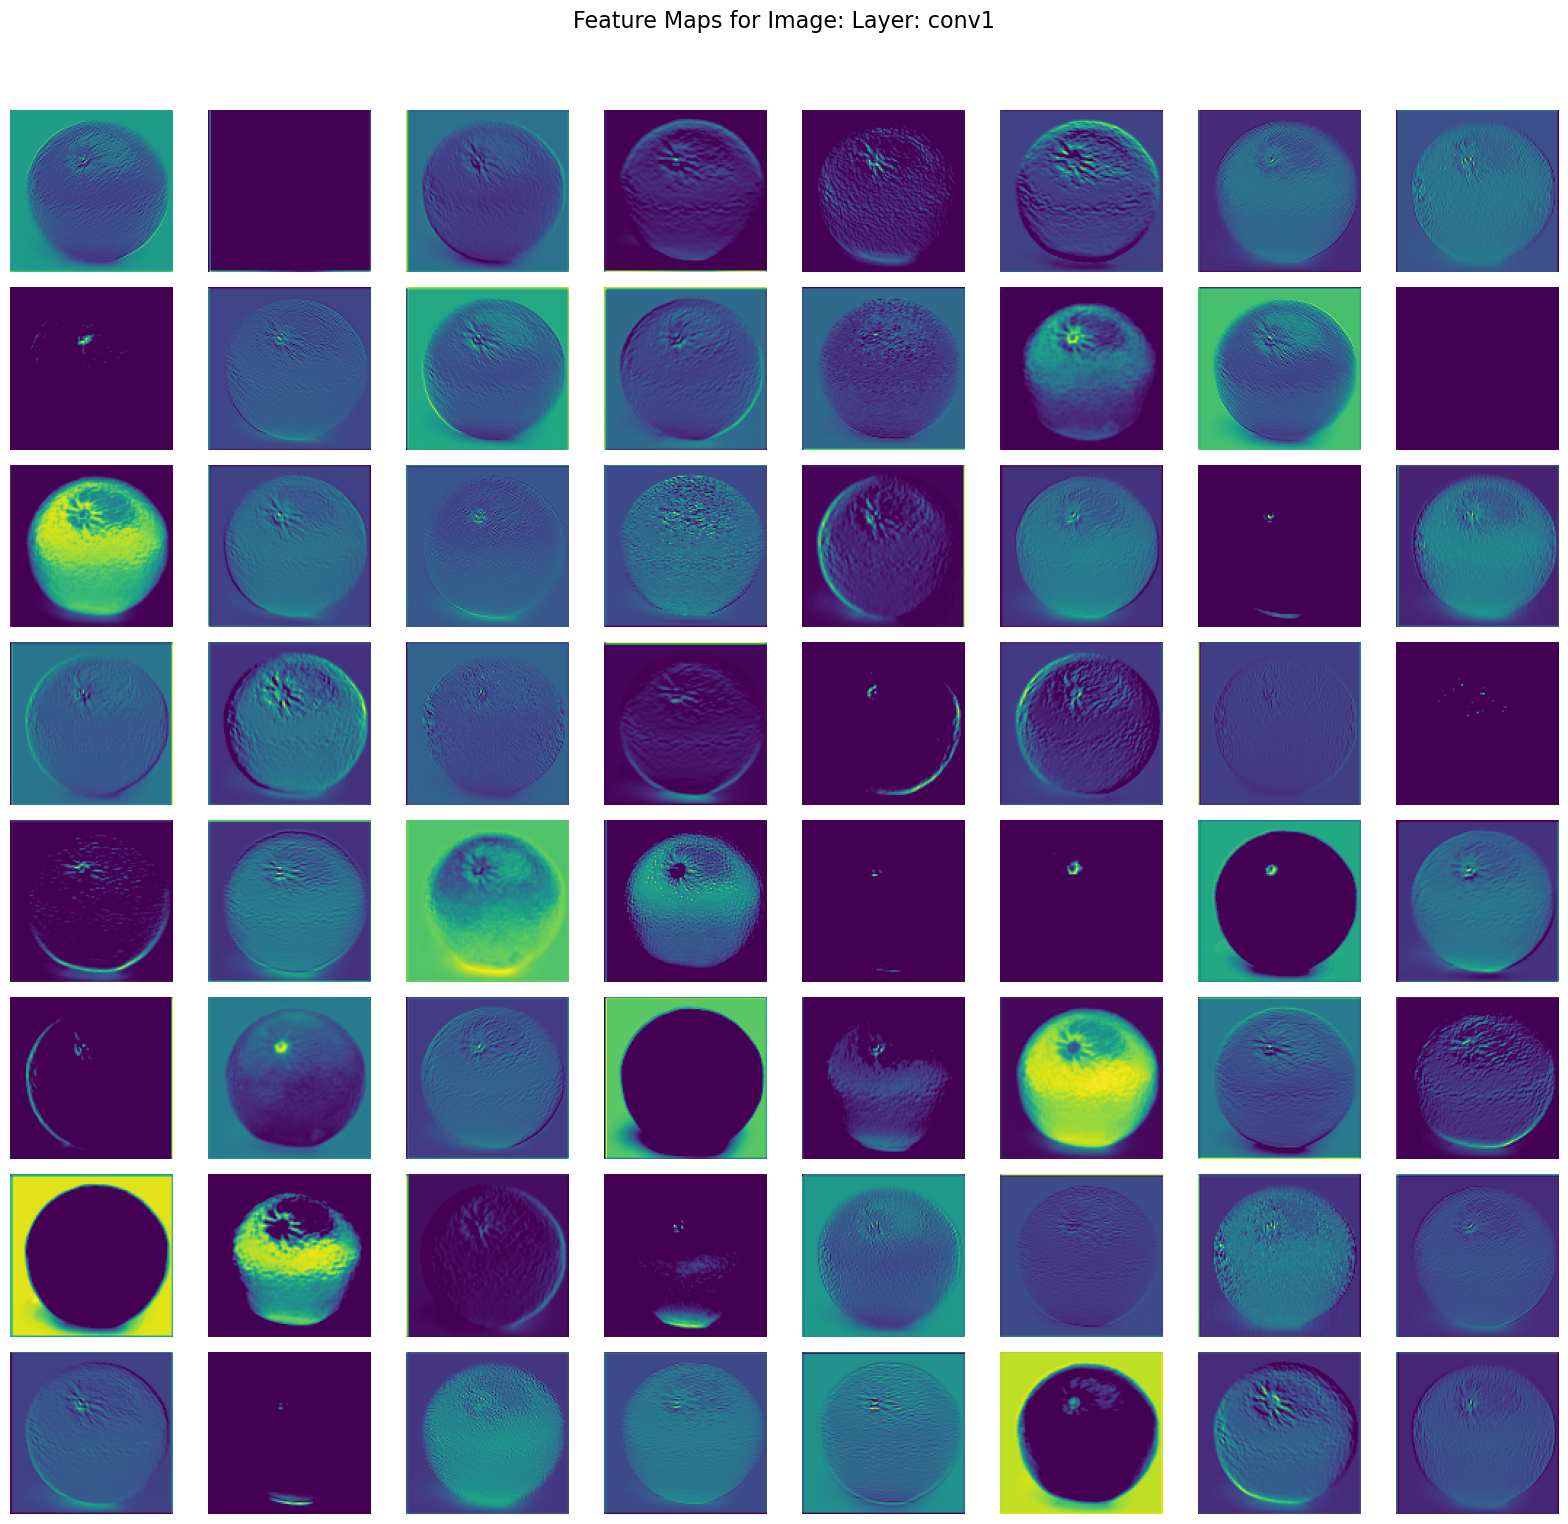

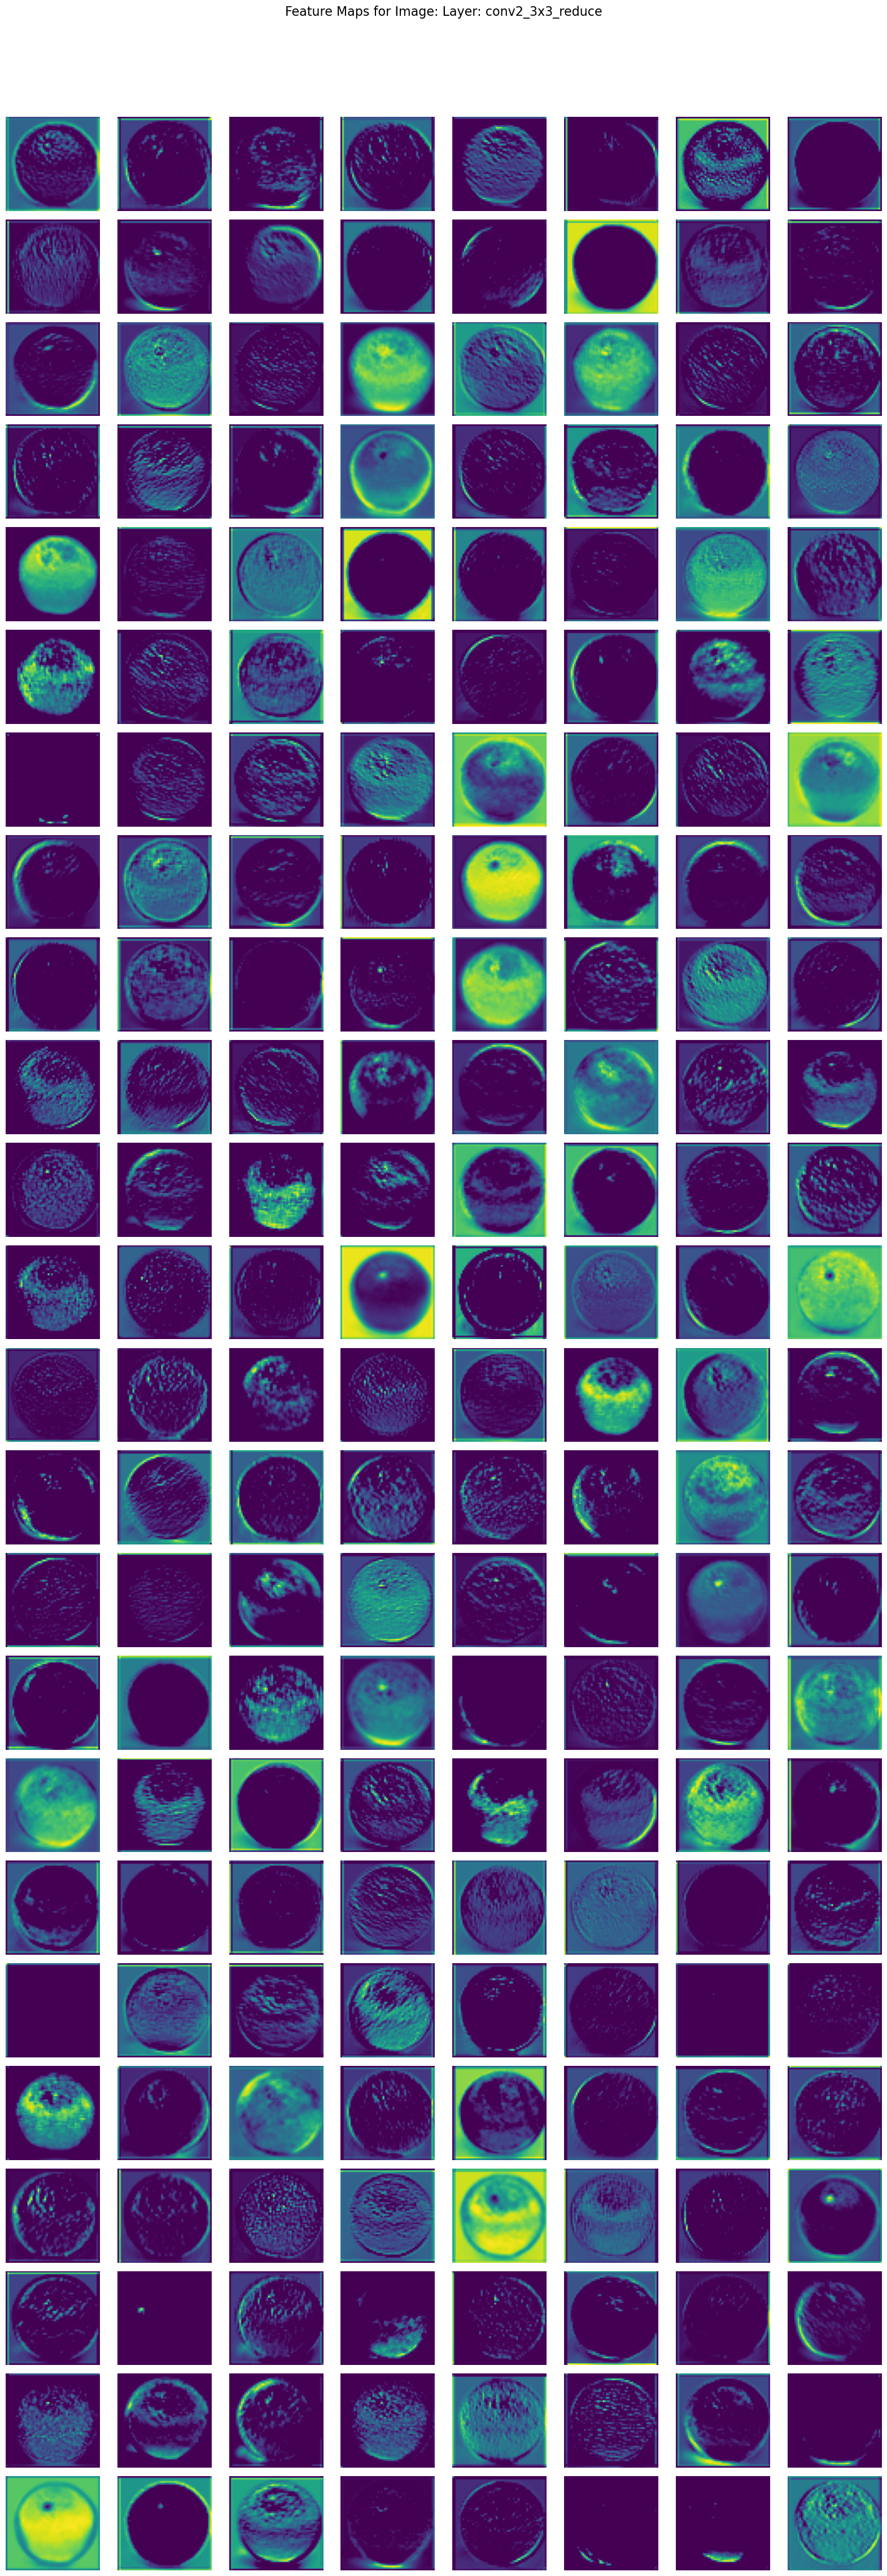

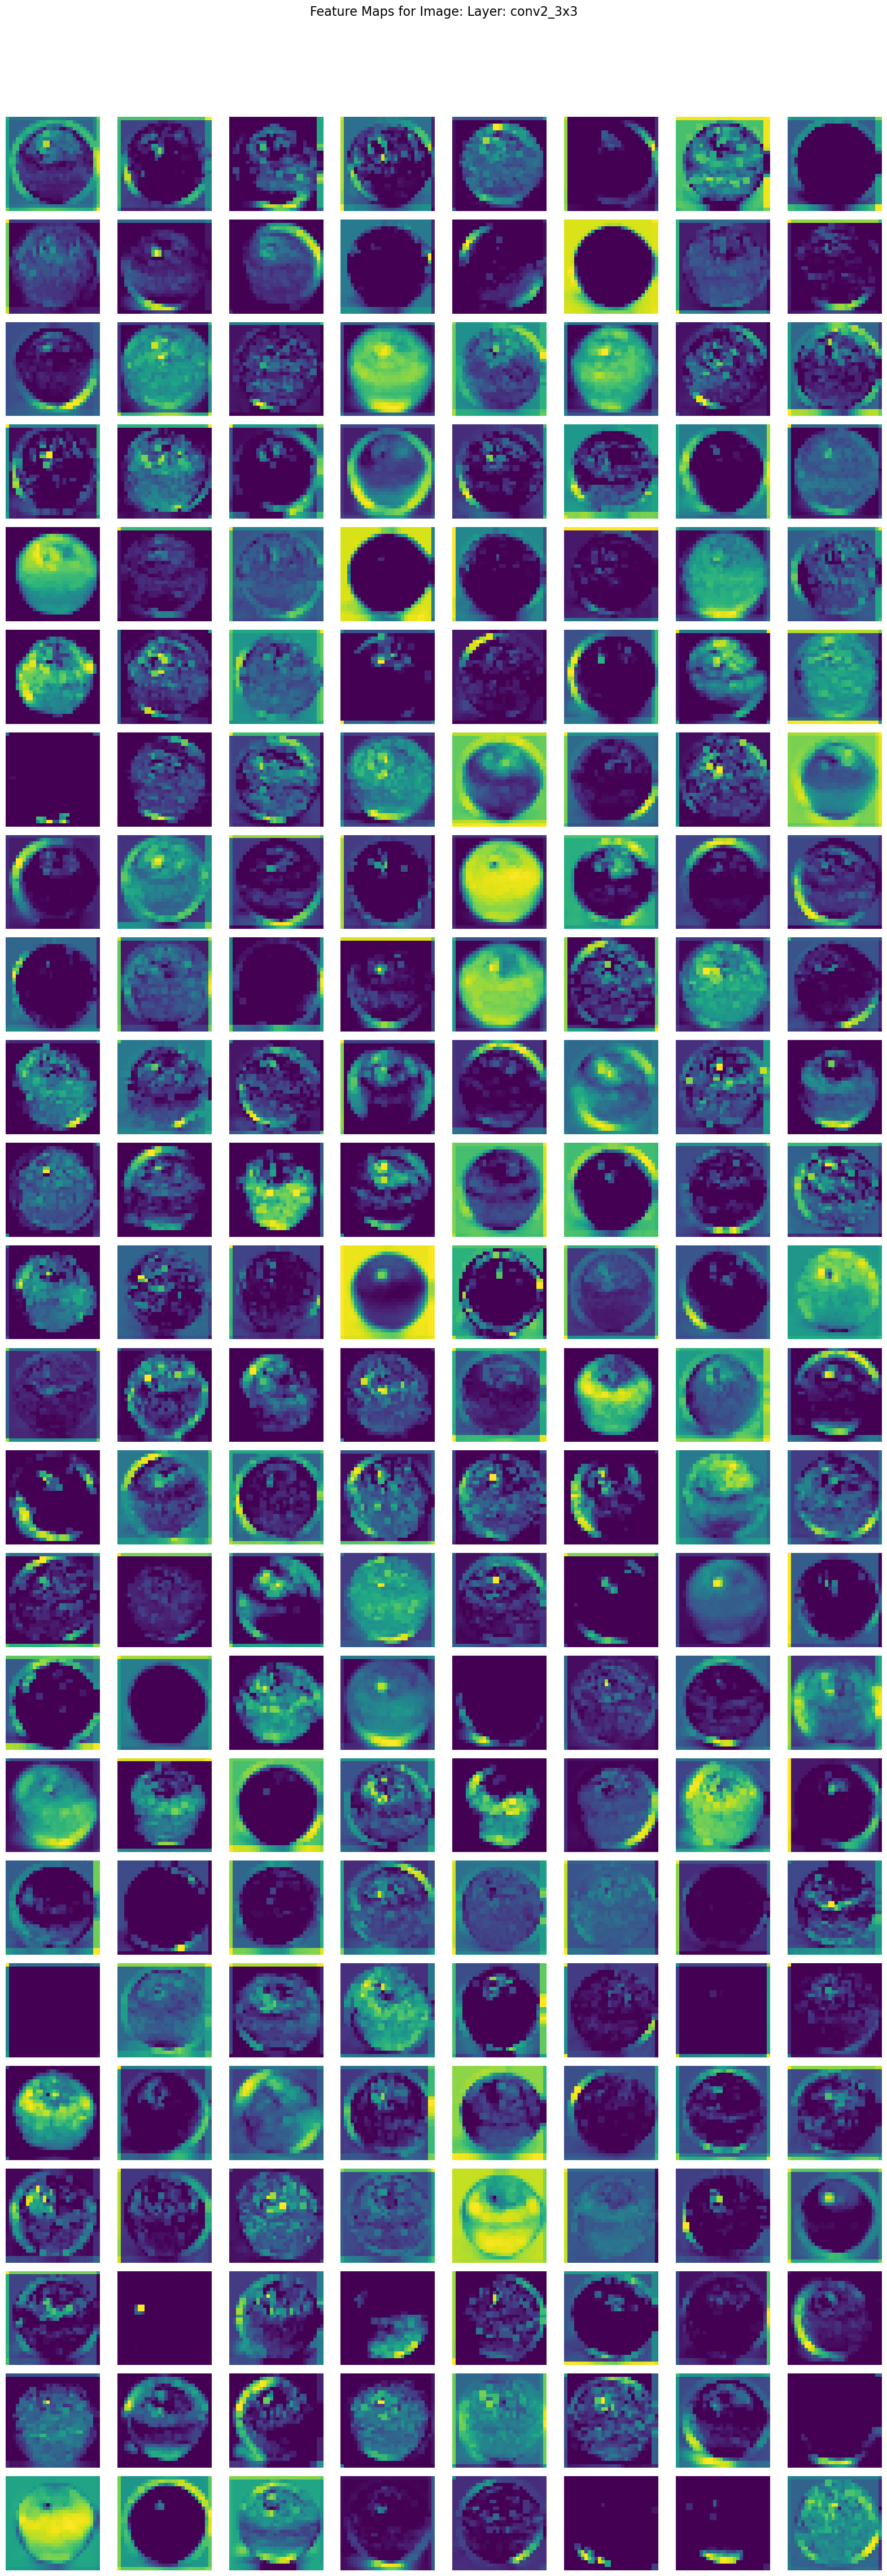

In [42]:
# 모델 훈련
train_model(model, criterion, optimizer, num_epochs=10)

# 첫 번째 배치에 대한 특징 맵 시각화
inputs, _ = next(iter(train_loader))
inputs = inputs.to(device)
model(inputs)
layer_names = ['conv1', 'conv2_3x3_reduce', 'conv2_3x3']
visualize_activation(activation, layer_names)

In [45]:
def test_model(model, test_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    all_preds = []
    all_labels = []
    with torch.no_grad():  # 검증을 위해 그라디언트를 종료하고, 메모리 사용량을 줄임
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)  # 수정된 부분
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
            all_preds.extend(preds.view(-1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    test_loss = running_loss / len(test_loader.dataset)
    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')
    
    # 결과 확인
    for i in range(5):
        print(f'Image: {test_dataset.img_names[i]} - Real: {test_dataset.classes[all_labels[i]]}, Predicted: {test_dataset.classes[all_preds[i]]}')
    return test_loss, test_acc


# Mooel load
test_loss, test_acc = test_model(model, test_loader, criterion)

Test Loss: 0.0734, Test Acc: 0.9833
Image: apple_77.jpg - Real: apple, Predicted: apple
Image: apple_78.jpg - Real: apple, Predicted: apple
Image: apple_79.jpg - Real: apple, Predicted: apple
Image: apple_80.jpg - Real: apple, Predicted: apple
Image: apple_81.jpg - Real: apple, Predicted: apple


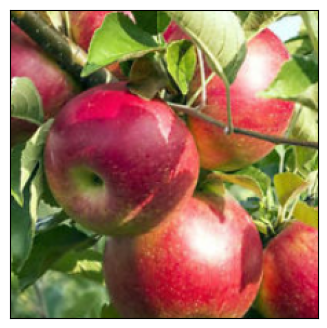

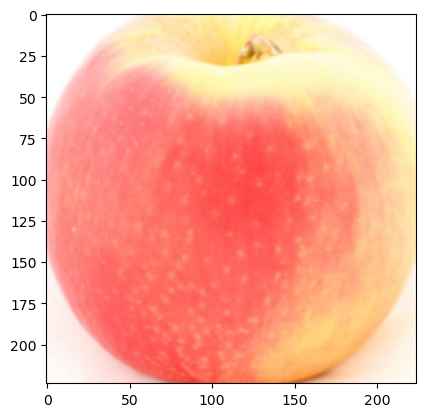

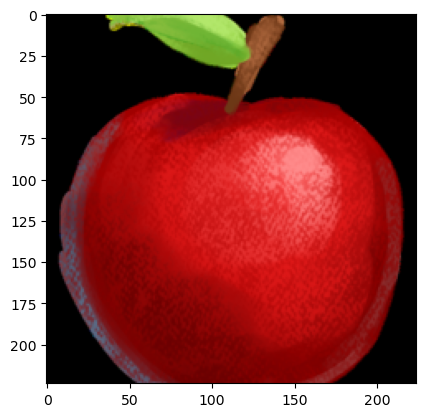

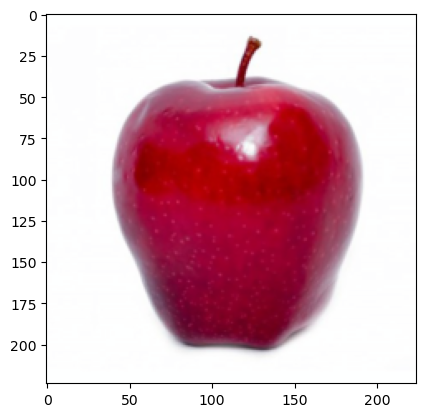

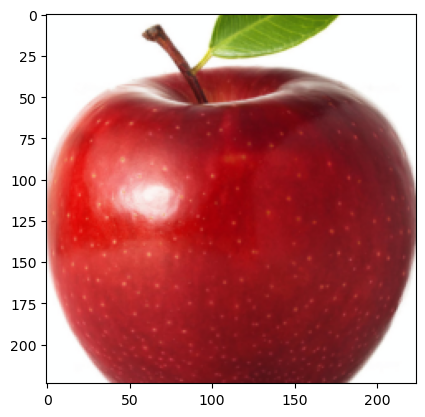

In [46]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# 테스트 데이터셋에서 이미지 및 레이블 가져오기
images, labels = next(iter(test_loader))

# 모델을 사용하여 예측
outputs = model(images.to(device))  # 수정됨
_, preds = torch.max(outputs, 1)

# 이미지 및 예측 결과 시각화
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(5):  # 5개의 이미지 샘플을 시각화
    ax = fig.add_subplot(1, 5, idx+1, xticks=[], yticks=[])
    imshow(images.cpu().data[idx])
    ax.set_title(f"Real: {test_dataset.classes[labels[idx]]}\nPredicted: {test_dataset.classes[preds[idx].cpu().numpy()]}")
plt.show()